# GCS Dijkstra

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from spp.convex_sets import Singleton, Polyhedron, Ellipsoid
from spp.convex_functions import TwoNorm, SquaredTwoNorm
from spp.graph import GraphOfConvexSets
from spp.shortest_path import ShortestPathProblem
from collections import defaultdict
import heapq as heap


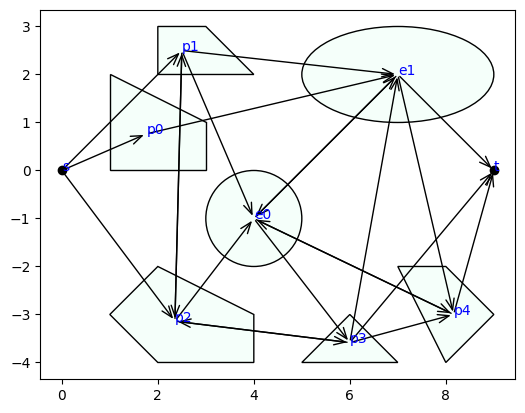

In [2]:
# convex sets
singletons = (
    Singleton((0, 0)),
    Singleton((9, 0)),
)
polyhedra = (
    Polyhedron.from_vertices(([1, 0], [1, 2], [3, 1], [3, 0])),
    Polyhedron.from_vertices(([4, 2], [3, 3], [2, 2], [2, 3])),
    Polyhedron.from_vertices(([2, -2], [1, -3], [2, -4], [4, -4], [4, -3])),
    Polyhedron.from_vertices(([5, -4], [7, -4], [6, -3])),
    Polyhedron.from_vertices(([7, -2], [8, -2], [9, -3], [8, -4])),
)
ellipsoids = (
    Ellipsoid((4, -1), ([1, 0], [0, 1])),
    Ellipsoid((7, 2), ([.25, 0], [0, 1])),
)
sets = singletons + polyhedra + ellipsoids

# label for the vertices
vertices = ['s', 't']
vertices += [f'p{i}' for i in range(len(polyhedra))]
vertices += [f'e{i}' for i in range(len(ellipsoids))]

# add convex sets to the graph
G = GraphOfConvexSets()
G.add_sets(sets, vertices)
G.set_source('s')
G.set_target('t')

# edges
H = np.hstack((np.eye(2), -np.eye(2)))
l = TwoNorm(H)
edges = {
    's': ('p0', 'p1', 'p2'),
    'p0': ('e1',),
    'p1': ('p2', 'e0', 'e1'),
    'p2': ('p1', 'p3', 'e0'),
    'p3': ('t', 'p2', 'p4', 'e1'),
    'p4': ('t', 'e0'),
    'e0': ('p3', 'p4', 'e1'),
    'e1': ('t', 'p4', 'e0')
}
for u, vs in edges.items():
    for v in vs:
        G.add_edge(u, v, l)
        
# draw convex sets and edges
plt.figure()
G.draw_sets()
G.draw_edges()
G.label_sets()
plt.show()

In [ ]:
spp = ShortestPathProblem(G, relaxation=0)


New subgraph after adding node from heap:


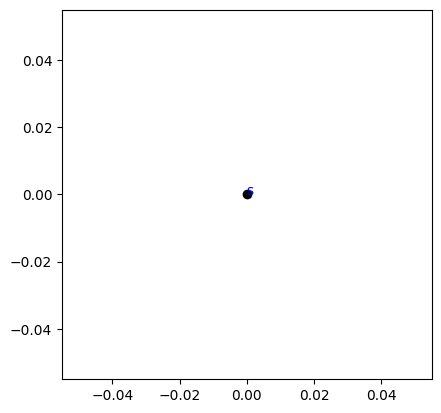

temp subgraph after adding relaxed node:


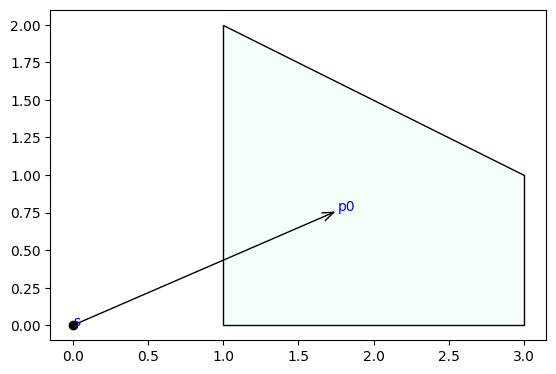

temp subgraph after adding relaxed node:


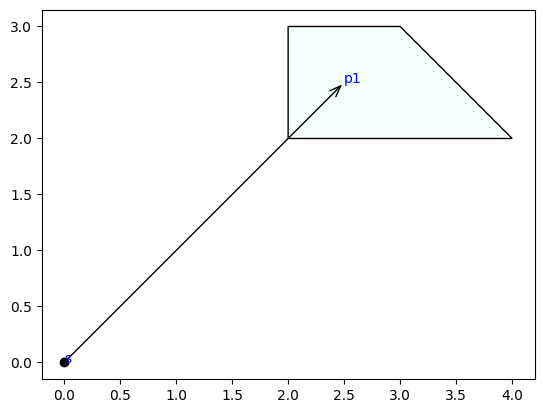

temp subgraph after adding relaxed node:


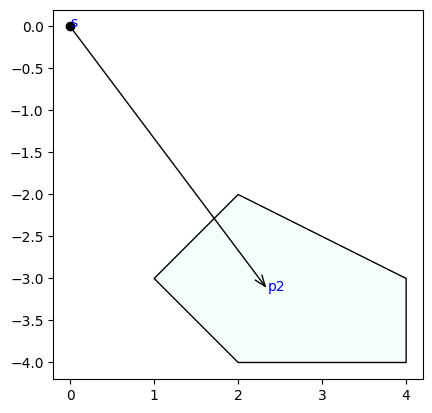

New subgraph after adding node from heap:


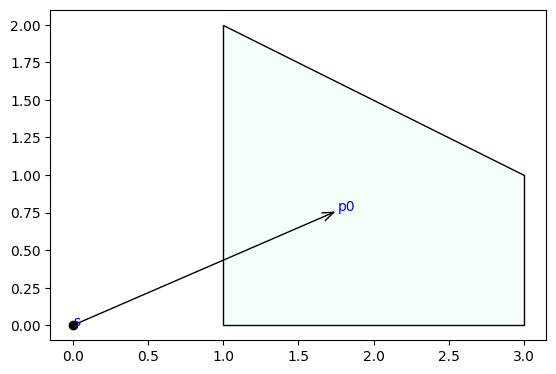

temp subgraph after adding relaxed node:


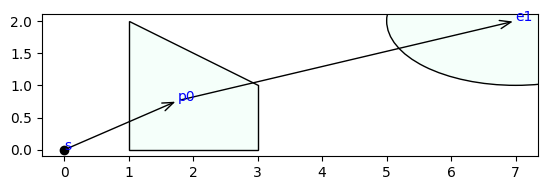

New subgraph after adding node from heap:


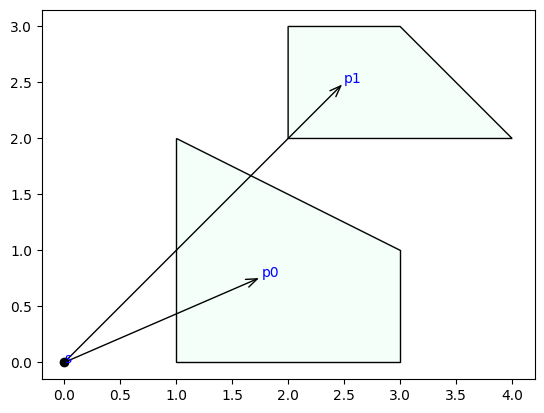

temp subgraph after adding relaxed node:


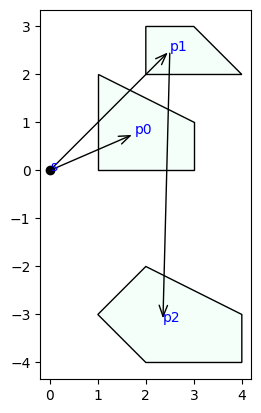

temp subgraph after adding relaxed node:


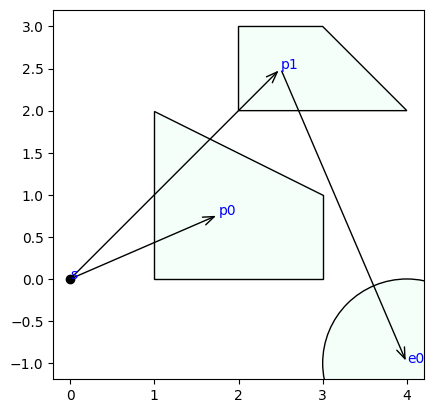

temp subgraph after adding relaxed node:


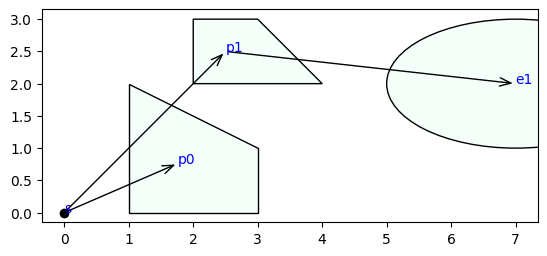

New subgraph after adding node from heap:


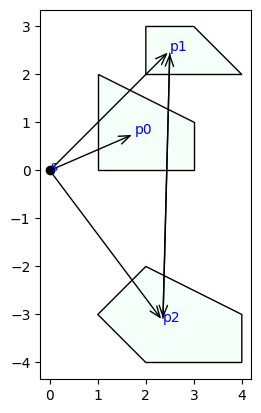

temp subgraph after adding relaxed node:


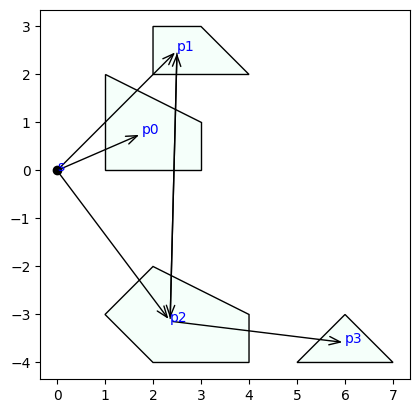

temp subgraph after adding relaxed node:


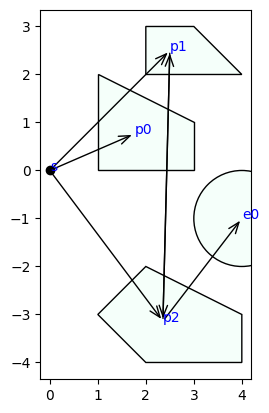

New subgraph after adding node from heap:


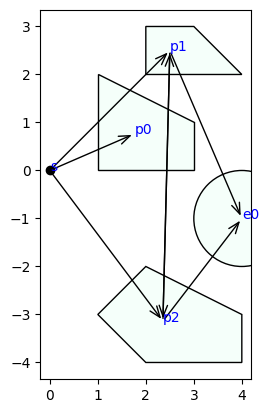

temp subgraph after adding relaxed node:


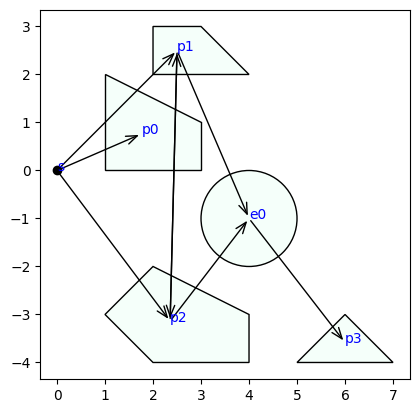

temp subgraph after adding relaxed node:


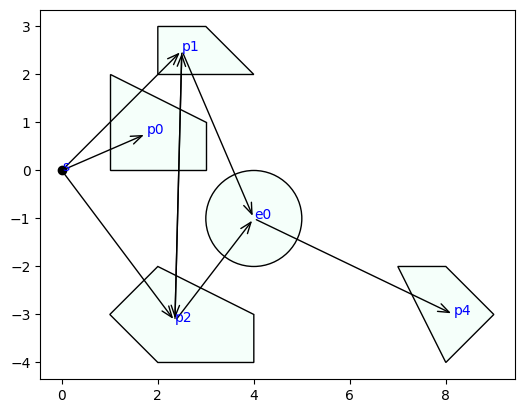

temp subgraph after adding relaxed node:


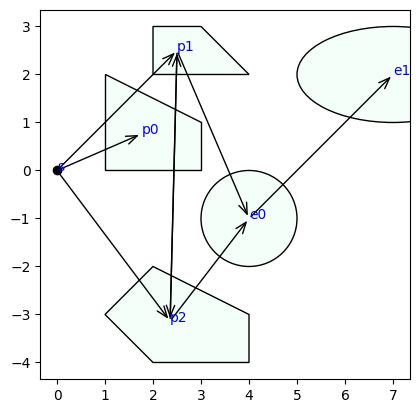

New subgraph after adding node from heap:


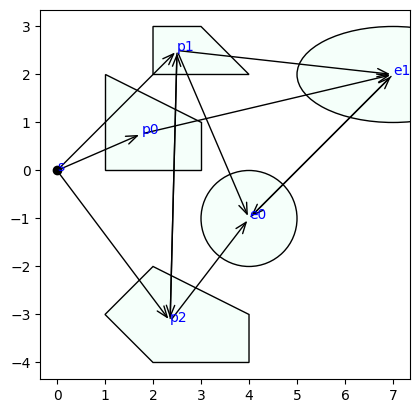

temp subgraph after adding relaxed node:


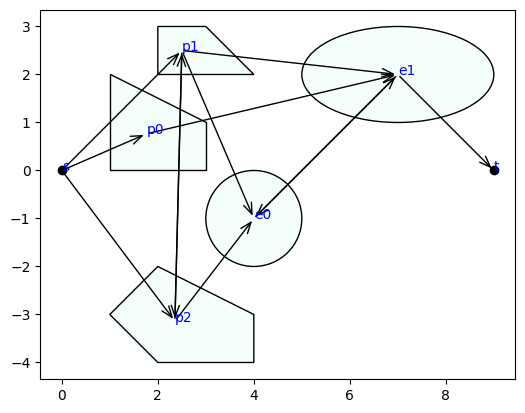

temp subgraph after adding relaxed node:


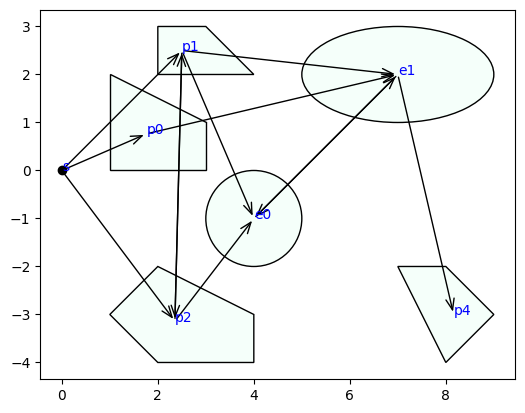

node e0 already visited
New subgraph after adding node from heap:


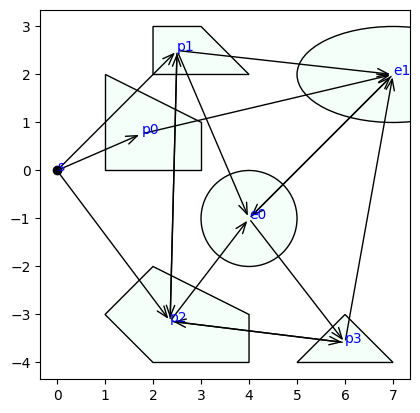

temp subgraph after adding relaxed node:


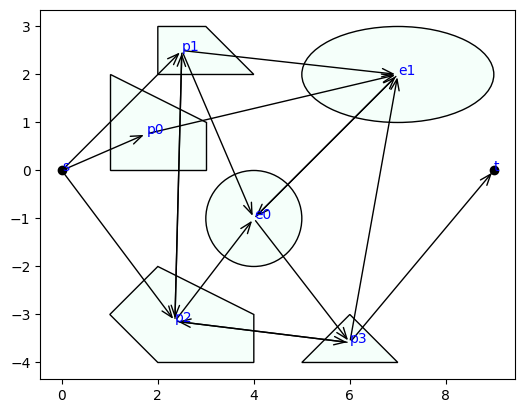

temp subgraph after adding relaxed node:


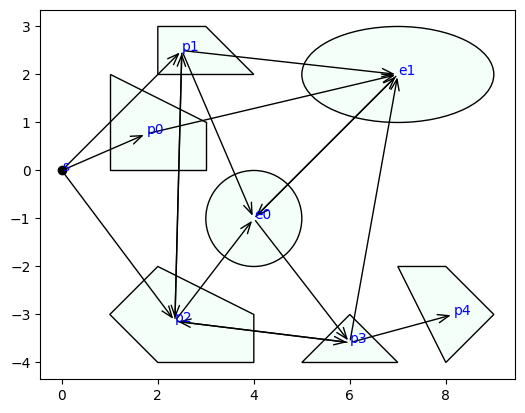

New subgraph after adding node from heap:


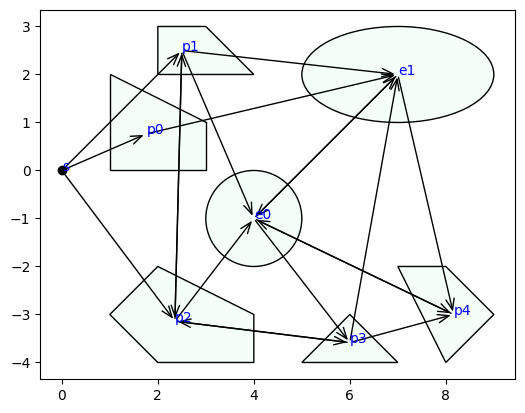

temp subgraph after adding relaxed node:


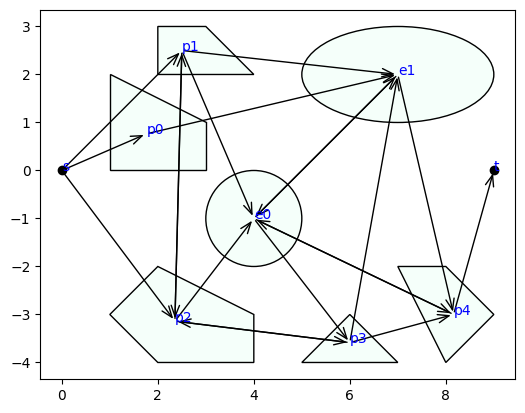

New subgraph after adding node from heap:


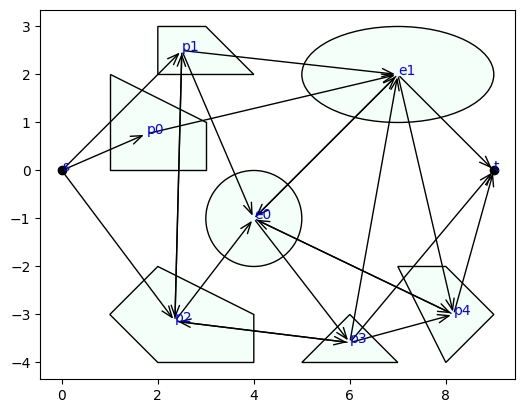

Cost: 9.28580890489365


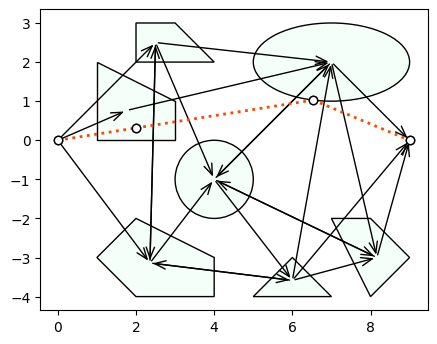

In [11]:
def gcs_dijkstra(original_graph):
    visited = set()
    pq = []
    node_dists = defaultdict(lambda: float('inf'))
    source = original_graph.source
    target = original_graph.target

    visited_subgraph = GraphOfConvexSets()
    

    node_dists[source] = 0
    heap.heappush(pq, (0, source))

    while len(pq) > 0:
        dist, node = heap.heappop(pq)
        if node in visited:
            print(f"node {node} already visited")
            continue
        
        visited.add(node)
        # Add node to the visited subgraph along with all of its incoming and outgoing edges to the visited subgraph
        visited_subgraph.add_set(original_graph.sets[node], node)
        edges, edge_indices = original_graph.outgoing_edges(node)
        for edge in edges:
            to_node = edge[1]
            if to_node in visited:
                visited_subgraph.add_edge(node, to_node, original_graph.lengths[(node, to_node)])
        edges, edge_indices = original_graph.incoming_edges(node)
        for edge in edges:
            from_node = edge[0]
            if from_node in visited:
                visited_subgraph.add_edge(from_node, node, original_graph.lengths[(from_node, node)])
        
        if node == source:
            visited_subgraph.set_source(source)
        
        print("New subgraph after adding node from heap:")
        plt.figure()
        visited_subgraph.draw_sets()
        visited_subgraph.draw_edges()
        visited_subgraph.label_sets()
        plt.show()

        if node == target:
            break
        edges, outgoing_edge_indices = original_graph.outgoing_edges(node)
        for edge in edges:
            neighbor = edge[1]
            if neighbor not in visited:
                # Add neighbor and edge temporarily to the visited subgraph NOTE: need to remove it after
                visited_subgraph.add_set(original_graph.sets[neighbor], neighbor)
                visited_subgraph.add_edge(node, neighbor, original_graph.lengths[(node, neighbor)])
                visited_subgraph.set_target(neighbor)

                spp = ShortestPathProblem(visited_subgraph, relaxation=0)
                sol = spp.solve()
                new_dist = sol.cost

                print("temp subgraph after adding relaxed node:")
                plt.figure()
                visited_subgraph.draw_sets()
                visited_subgraph.draw_edges()
                visited_subgraph.label_sets()
                plt.show()
                
                # Remove neighbor and edge from the visited subgraph
                visited_subgraph.remove_edge((node, neighbor))
                visited_subgraph.remove_set(neighbor)

                if new_dist < node_dists[neighbor]:
                    node_dists[neighbor] = new_dist
                    heap.heappush(pq, (new_dist, neighbor))

    # Solve GCS for a final time to extract the path
    visited_subgraph.set_target(target)
    spp = ShortestPathProblem(visited_subgraph, relaxation=0)
    sol = spp.solve()
    plt.figure(figsize=(5,5))
    visited_subgraph.draw_sets()
    visited_subgraph.draw_edges()
    visited_subgraph.draw_path(sol.primal.phi, sol.primal.x, color='orangered', linestyle=':', linewidth=2)
    print(f"Cost: {sol.cost}")
gcs_dijkstra(G)